# Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import datasets

np.random.seed(1234)

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (16, 4)})
import seaborn as sns

sns.set()

# 13.1 Motivation

KNN has disadvantage that to classify a new point, you have to consider all the training data  
Whereas with regression you only need to evaluate the model coef  
Logistic regression uses regression to predict probability that a value belongs to each class, thus it is not directly a classifier

Data load - IRIS

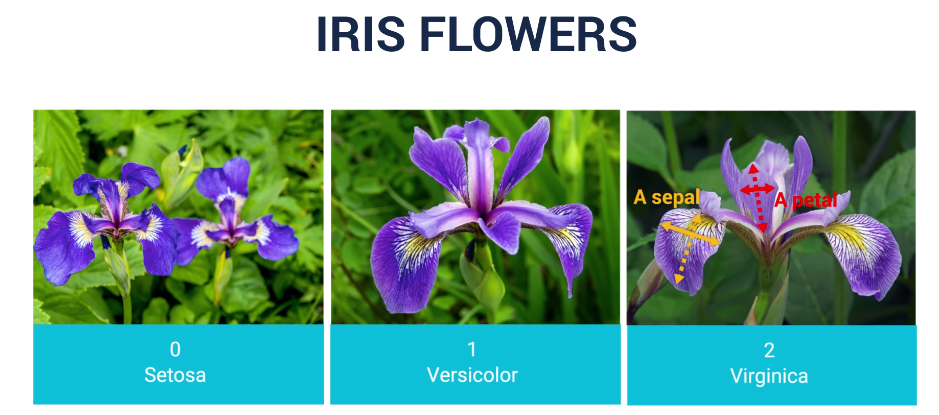

Example problem, try to classify between virginica and versicolor based on petal length only
- Fit a line to the data points
- Choose a threshold to be the petal length that gives equal probability to both species
- That means compute y = f(x) where
    - x is the petal length
    - y is 0 = versicolor and y = 1 is virginica
    - f is the line fit
    - Then declare the threshold to be x such that y = f(x) = 0.5

Problematic though, because very sensitive to outliers
- Not shown here, but if a new data point comes in with a petal length way outside of this range, the line fit can change signficantly

Note this is demonstrating the sensitivity of **linear** regression, not logistic
- The above methodology demonstrates how you could try and solve classification using linear regression
- This is what **not** to do!
- It works, just not very well

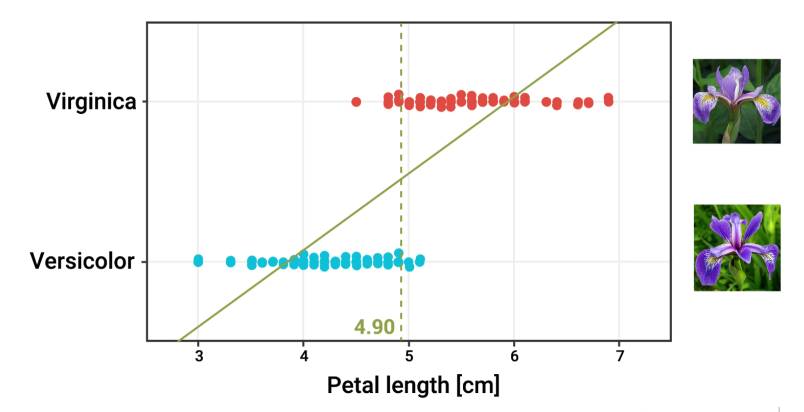

# 13.2 One Feature, Two Classes

In [3]:
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names).join(
    pd.Series(iris["target"], name="Species")
)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
df_vv_only = df.loc[df["Species"].isin([1, 2])].reset_index(drop=True)
df_vv_only

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,7.0,3.2,4.7,1.4,1
1,6.4,3.2,4.5,1.5,1
2,6.9,3.1,4.9,1.5,1
3,5.5,2.3,4.0,1.3,1
4,6.5,2.8,4.6,1.5,1
...,...,...,...,...,...
95,6.7,3.0,5.2,2.3,2
96,6.3,2.5,5.0,1.9,2
97,6.5,3.0,5.2,2.0,2
98,6.2,3.4,5.4,2.3,2


LinearRegression()


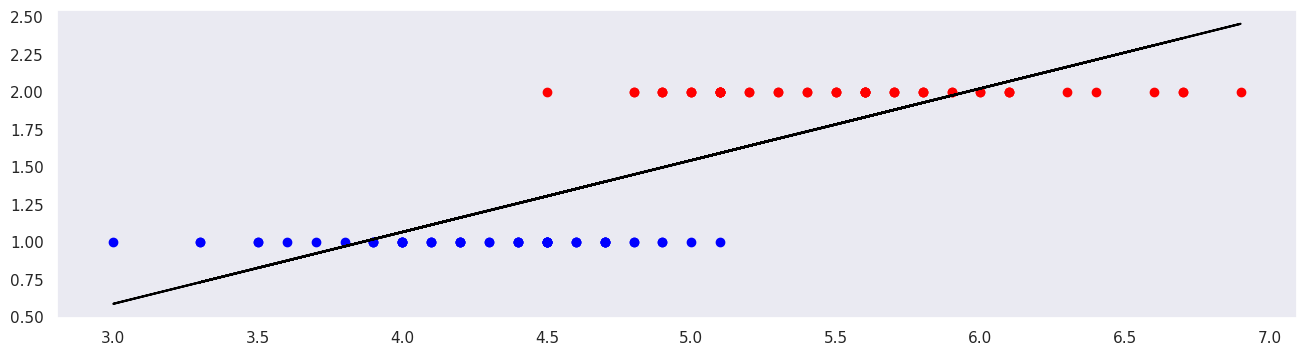

In [5]:
X = df_vv_only[["petal length (cm)"]]
y = df_vv_only["Species"]  # .map({1:0, 2:1})
model = LinearRegression().fit(X, y)

mask = y == 1

# Answer check
print(model)
plt.scatter(X.to_numpy()[mask], y[mask], color="blue")
plt.scatter(X.to_numpy()[~mask], y[~mask], color="red")
plt.plot(X.to_numpy(), model.predict(X), color="black")
plt.grid()

Classifier Example

The threshold separating the 2 species is where P(Y = virginica) = P(Y = versicolor) = 0.5

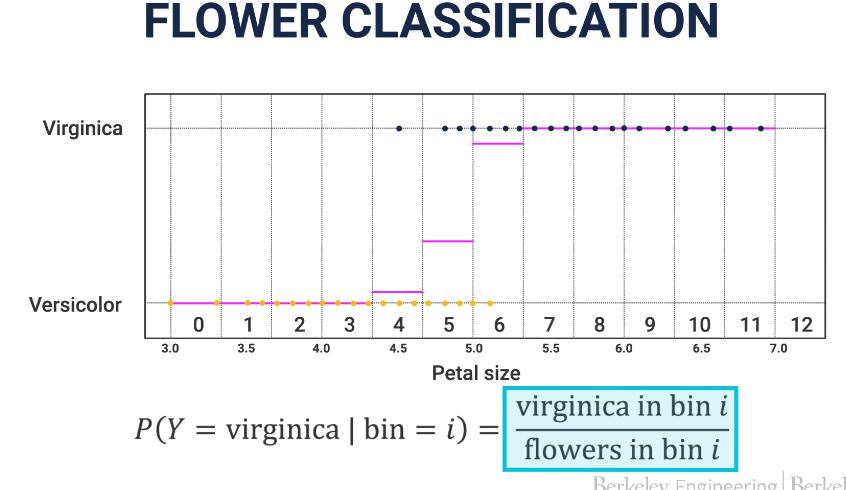

Approach - assume marginal distribution for each is the same and gaussian. Also assume (not shown below) they have the same variance = v^2

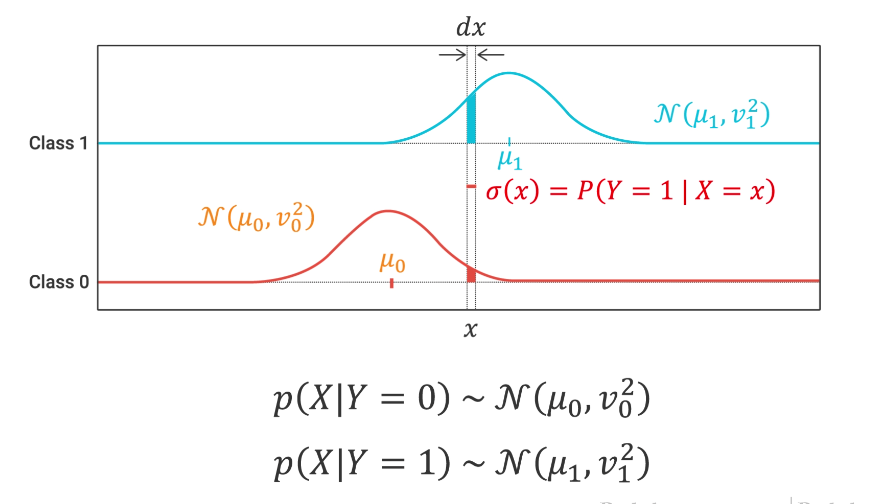

Odds ratio is

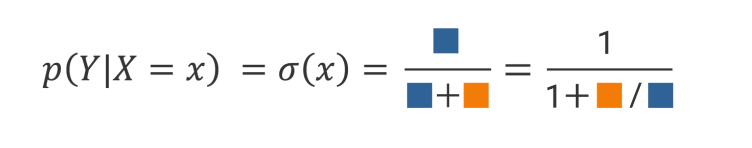

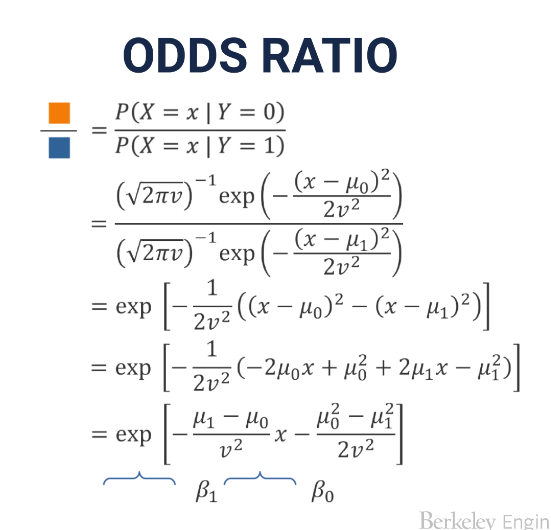

Notice it is an exponential of a linear function in x

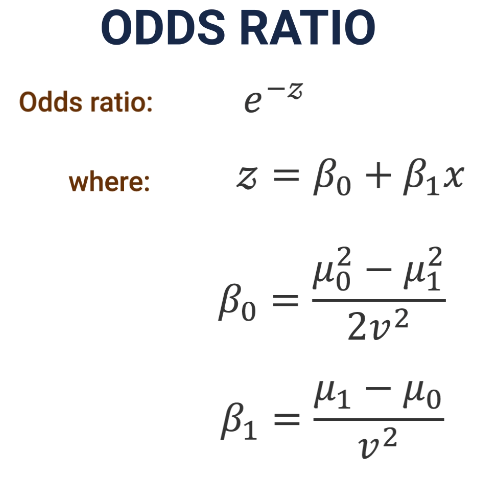

Sigmoid function AKA logistic function

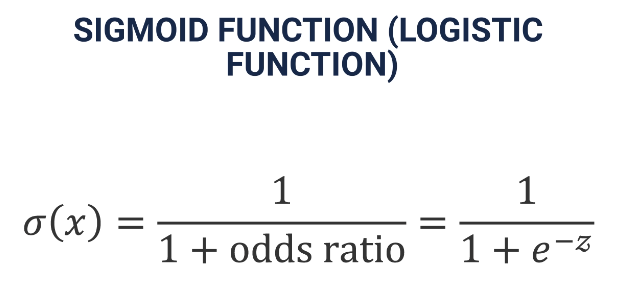

Choose a threshold xbar separating the class such that sigmoid(xbar) = 0.5

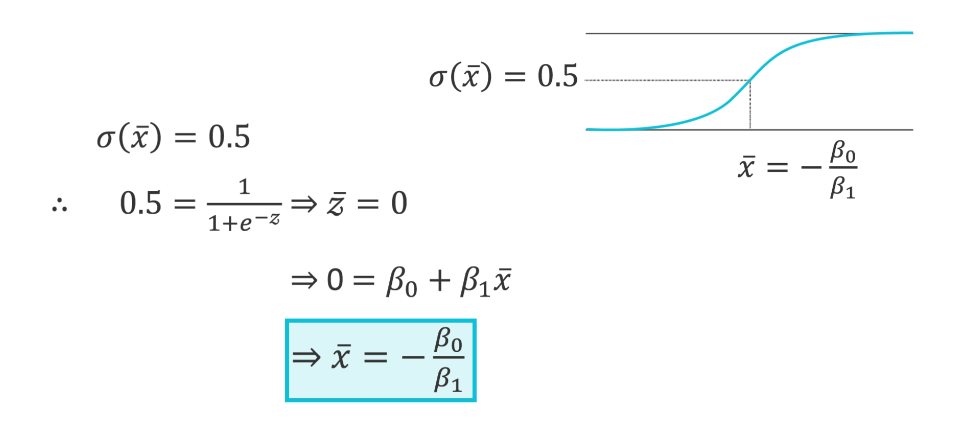

How to get the beta values? First guess, take the "approximate solution". Not going to be good enough in general.

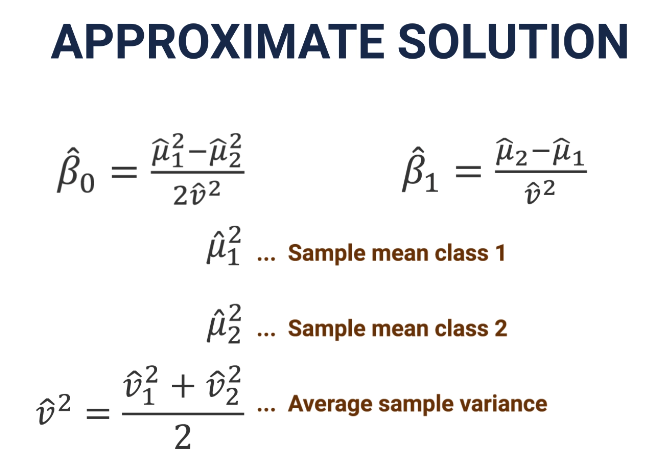

Next, define the likelihood function:

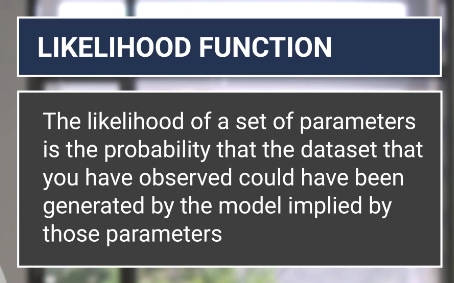

Consider the following graph showing 2 possible models. Which one seems more "likely"?
- Probably the purple, not the blue
- Because for the blue to be true, all of those green and red samples would have to have come from the far tails of the distributions implied the model parameters
- Possible, but not very... likely
- Instead, the purple model seems more likely, since the samples live around the means of each marginal distribution

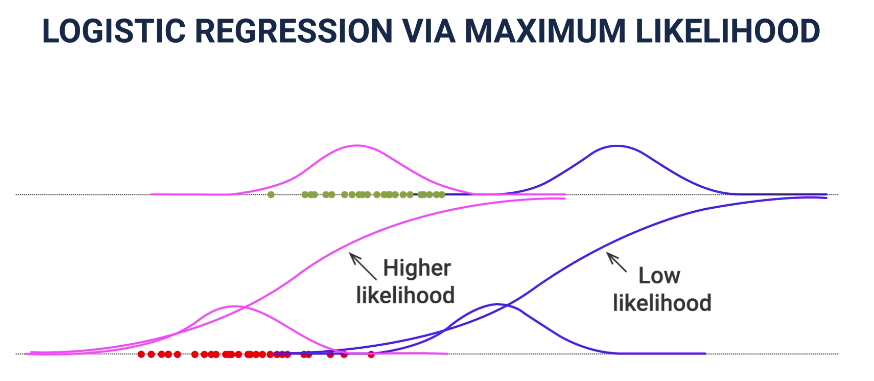

How to quantify how likely one is? Formula time

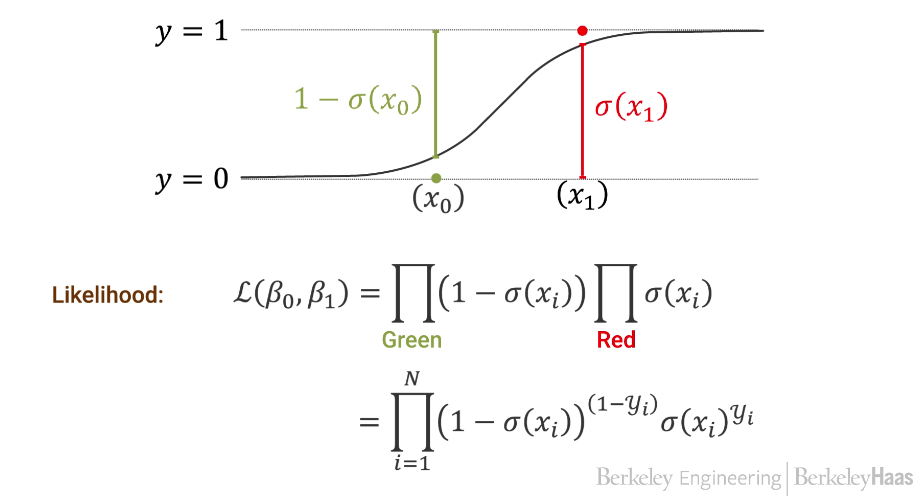

Now take log to convert the product to sum. Final term is the negative of the cross-entropy
- i.e., put a minus sign in front of the summation, and that is cross entropy

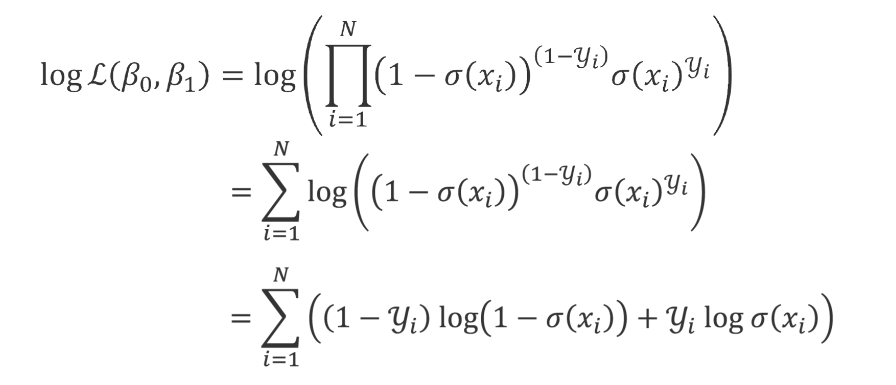

Instead of maximizing likelihood, for the optimization target you minimize the cross entropy. Taking it all in one shot:

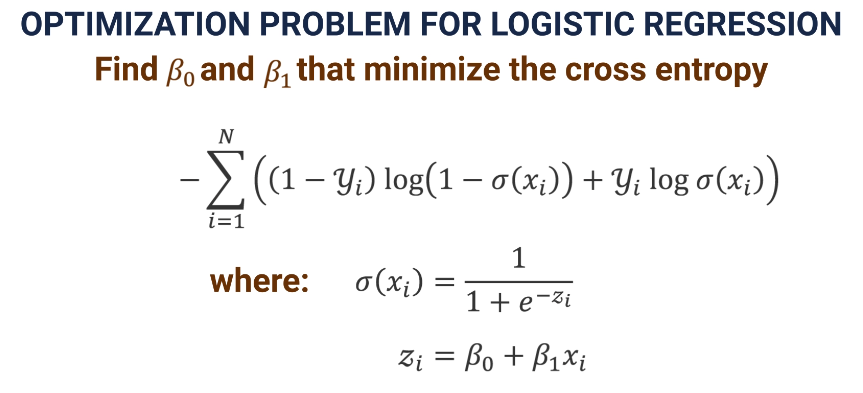

# 13.3 One Feature, Two Classes, in Code

In [6]:
data = datasets.load_iris()
iris = pd.DataFrame(data=data["data"], columns=data.feature_names).join(
    pd.Series(data["target"], name="species")
)
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [7]:
iris.columns = ["sl", "sw", "pl", "pw", "species"]
iris

,sl,sw,pl,pw,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [8]:
iris_2species = iris.loc[iris["species"].isin([1, 2])].reset_index(drop=True)
iris_2species

,sl,sw,pl,pw,species
0,7.0,3.2,4.7,1.4,1
1,6.4,3.2,4.5,1.5,1
2,6.9,3.1,4.9,1.5,1
3,5.5,2.3,4.0,1.3,1
4,6.5,2.8,4.6,1.5,1
...,...,...,...,...,...
95,6.7,3.0,5.2,2.3,2
96,6.3,2.5,5.0,1.9,2
97,6.5,3.0,5.2,2.0,2
98,6.2,3.4,5.4,2.3,2


In [9]:
X = iris_2species[["pl"]]
y = iris_2species["species"]

In [10]:
lr_model = LogisticRegression().fit(X, y)
lr_beta0 = lr_model.intercept_[0]
lr_beta1 = lr_model.coef_[0][0]
lr_thresh = -lr_beta0 / lr_beta1
[lr_beta0, lr_beta1, lr_thresh]

[-17.509046997389056, 3.5908268927965423, 4.87604875426144]

Model interpretation - flowers with petal lengths >= 4.87 will be classified as 2 = virginica

Compare to approximate solution

In [11]:
X1 = X[y == 1].to_numpy()
X2 = X[y == 2].to_numpy()
mu1 = np.mean(X1)
mu2 = np.mean(X2)
v = 0.5 * (X1.var() + X2.var())
ax_beta0 = (mu1**2 - mu2**2) / 2 / v
ax_beta1 = (mu2 - mu1) / v
ax_thresh = -ax_beta0 / ax_beta1
[ax_beta0, ax_beta1, ax_thresh]

[-24.62070787110408, 5.0184891706286345, 4.906]

In [12]:
def sigmoid(beta0, beta1, x):
    return 1.0 / (1.0 + np.exp(-(beta0 + beta1 * x)))

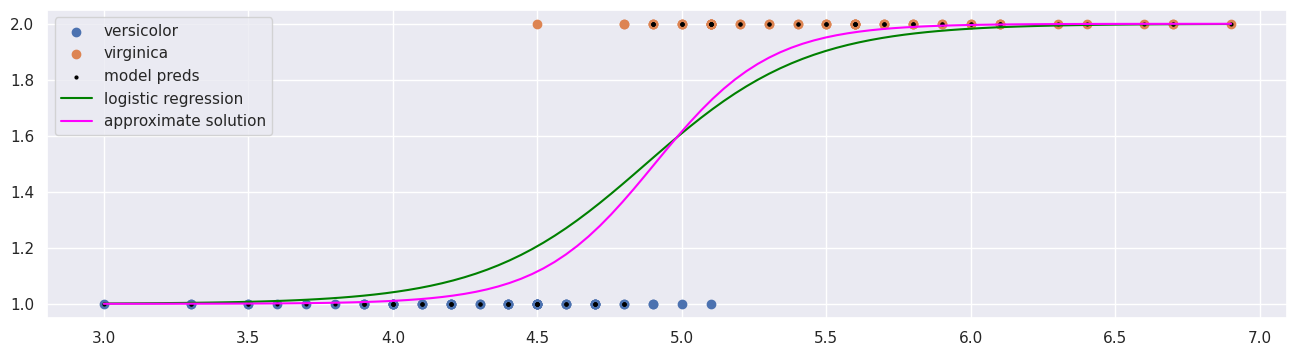

In [13]:
x = np.linspace(X.min(), X.max(), 101)
plt.figure()
plt.scatter(X1, np.zeros(len(X1)) + 1, label="versicolor")
plt.scatter(X2, np.zeros(len(X2)) + 2, label="virginica")
plt.scatter(X, lr_model.predict(X), label="model preds", color="black", s=4)
plt.plot(
    x, sigmoid(lr_beta0, lr_beta1, x) + 1.0, color="green", label="logistic regression"
)
plt.plot(
    x,
    sigmoid(ax_beta0, ax_beta1, x) + 1.0,
    color="magenta",
    label="approximate solution",
)
plt.legend()

# 13.4 Many Features

Moving beyond the restriction of just one feature, move on initially to 2 values. Here's the definition of a data set

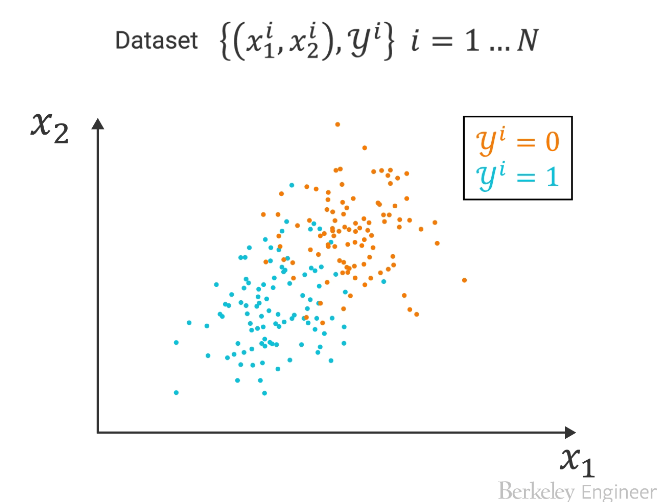

How to handle a new value x? As before, do
- Draw a box around x
- Count the number of each class in that box
- Then decide x is the one with the most counts - "majority vote"

Equation for log odds below, same as before but replace variance with covariance E, and x is vector-valued

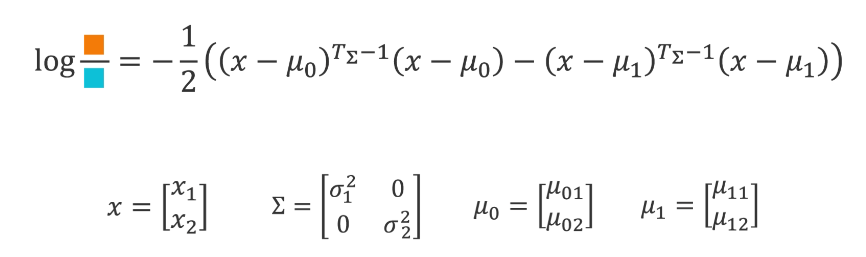

After moving some terms around, notice the equation is still a linear model in beta0, beta1, and new term beta2 for new variable (feature) x2

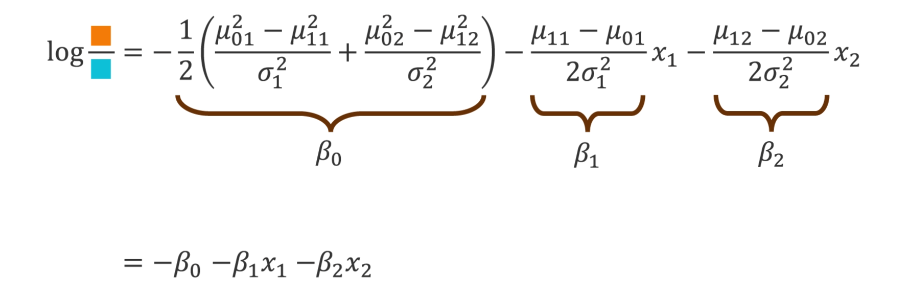

Now this can be generalized for M features with the following
- Remember that what this is solving is the probability that a sample x is of class Y = 1
- sigmoid = logistic function = a probability
- I think there is an error in the picture below - you minimize the negative of that function

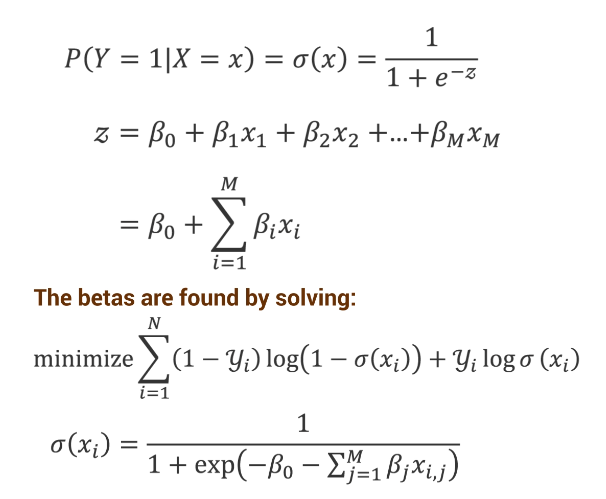

New problem - what if the classes are perfectly separated?
- i.e. there is a threshold that perfectly separates them

In that case, how do you evaluate candidate models? Return to the likelihood function
- In the figure below, consider 2 candidate solutions in blue and pink
- Which one has the higher likelihood?
- To get likelihood you take the product of sigma(xi)^(yi)*(1-sigma(xi))^(1-yi)
- For a 2 class problem, yi = 1 or 0
- So at any point i, only of the above terms is non-vanishing, since the other would be raised to power of 0
- So you end up taking the product of either 1-sigma(xi) or sigma(xi)
- So he states that the higher likelihood is the one with taller lines everywhere

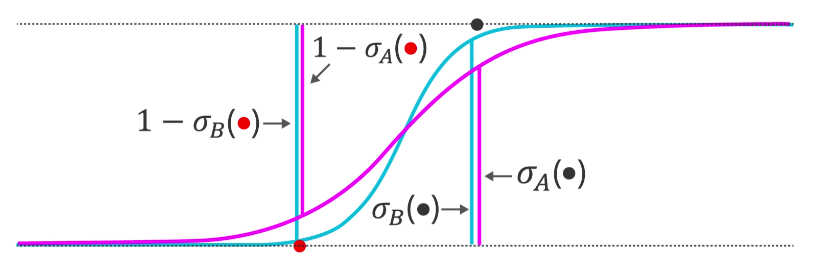

But you can keep trying more models, until you end up with a step function, and betas go to infinity

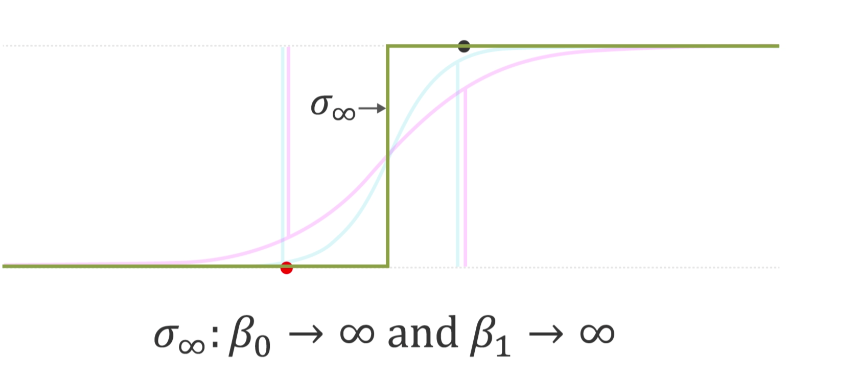

To avoid having betas go to infinity, you can regularize by introducing a cost function that along with the cross entropy is minimized
- As before, there are lasso (L1) and ridge (L2) regularizers
- In scikit, the parameter c is 1/lambda, so to *increase* regularization, you *decrease* c

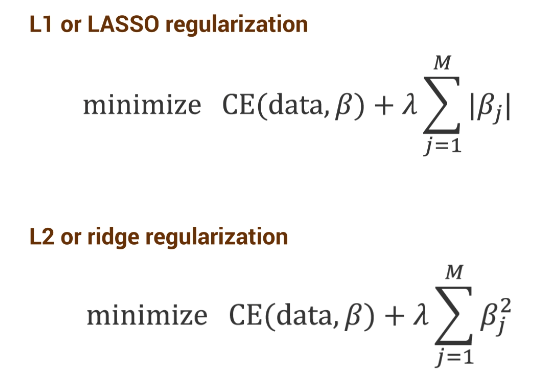

# 13.5 Many Features, in Code

In [14]:
X = iris_2species[["pl", "pw"]]
y = iris_2species["species"]
lr = LogisticRegression().fit(X, y)
[lr.intercept_, lr.coef_]

[array([-17.55814728]), array([[2.77980871, 2.38512529]])]

In [15]:
def plot_region(lr, d1_lim, d2_lim):
    eps = 0.02
    d1_grid, d2_grid = np.meshgrid(
        np.arange(d1_lim[0], d1_lim[1], eps), np.arange(d2_lim[0], d2_lim[1], eps)
    )
    d12_array = np.c_[d1_grid.ravel(), d2_grid.ravel()]
    y_grid = lr.predict(d12_array).reshape(d1_grid.shape)
    plt.contourf(d1_grid, d2_grid, y_grid, cmap="Pastel2", alpha=0.5)

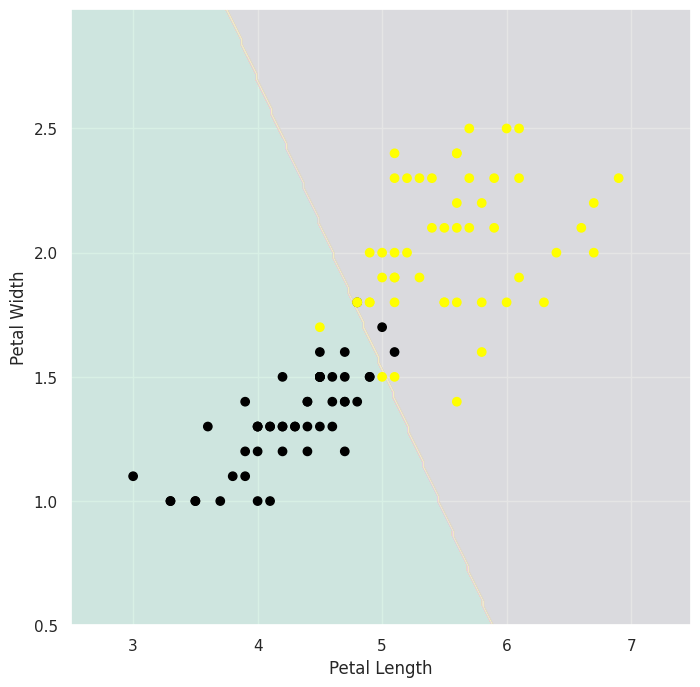

In [16]:
plt.figure(figsize=(8, 8))
plot_region(lr, [2.5, 7.5], [0.5, 3.0])
plt.scatter(
    x=iris_2species["pl"],
    y=iris_2species["pw"],
    c=iris_2species["species"].map({1: "black", 2: "yellow"}),
)

plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.grid(True)

# 13.6 Multiclass Problems

Dealing with variables with non-binary outcomes
- Binary classification methods are *adapted* to handle multi-class
- As opposed to their being wholesale different methods

## Methods Introduced

Three methods are available
- One vs.
    - Generic and can be used with other classification models aside from logistic regression
    - One vs. rest (OVR)
        - Requires underlying classification model returns a continuous probability for the prediction
        - Not simply a binary class assignment
    - One vs. one
        - Does not require a continuous probability prediction
        - Can be used to extend any binary classifier into multi-class problems
- Multinomial regression
    - Generalization of logistic regression

Example setup - 2-dimensional problem with 4 classes
- Capital K for number of classes
- So here K=4

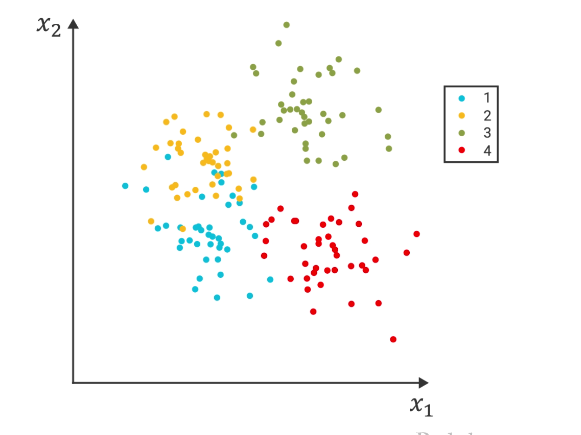

## One vs. Rest (OVR)

OVR
- Uses a binary classifier to build K separate models
- Each model pits one class against all others
- So the model is classifying in-class, not-in-class
- For example, first model compares class = 1, to classes 2, 3, 4
- If the classifier is logistic regression, then the probability is logistic function (sigmoid)
- To predict class of new model, you evaluate all 4 models (sigma functions) and choose highest
- OVR is a linear classifier, because the decision boundaries are all lines

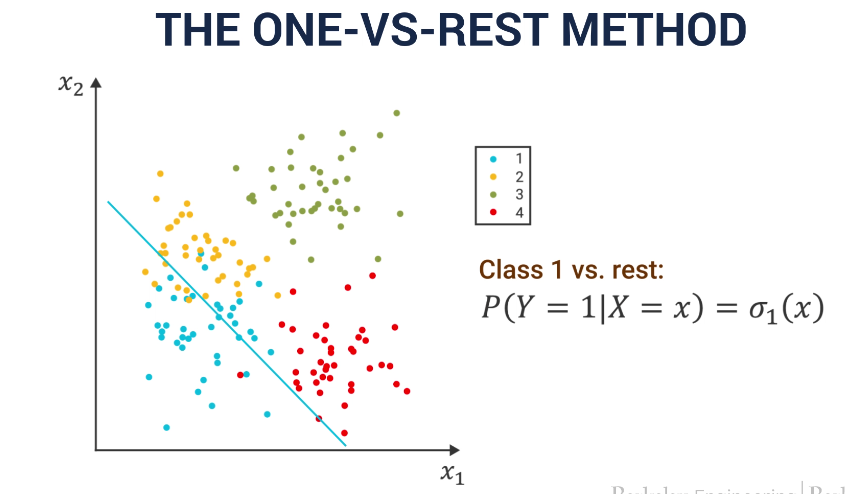

## One vs. One

One vs. one does
- Builds classifiers for every pair
- Does not require a continuous probability function from the underlying classification method
- Needs k*(k-1)/2 models
- To classify a new data point, evaluate all models, then choose by majority vote
    - Example, if there are 3 classes, there are 3 models
    - Evaluate all 3 models
    - Choose class most often declared
    - Example
        - 1 vs. 2 says 2
        - 1 vs. 3 says 1
        - 2 vs. 3 says 2
        - Since 2 got most votes, 2 is prediction
    - How are ties handled?

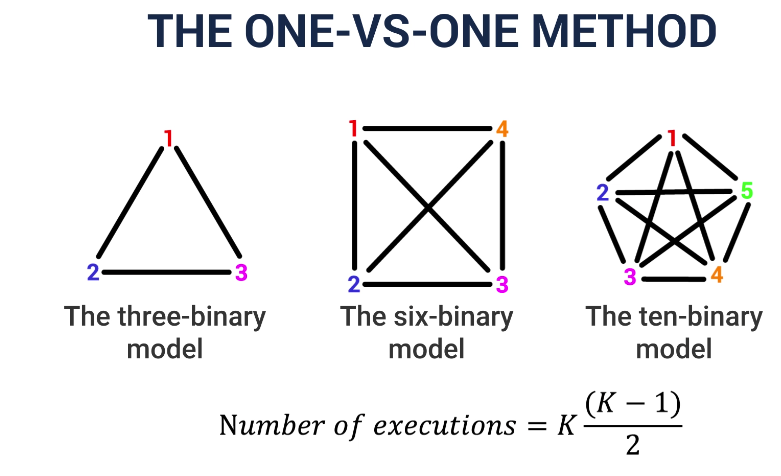

Here are the decision regions for one vs. one
- Again the boundaries are lines so its called a linear classifier
- The white unshaded area are tie regions
- Cannot be classified
- So what is answer? NaN?

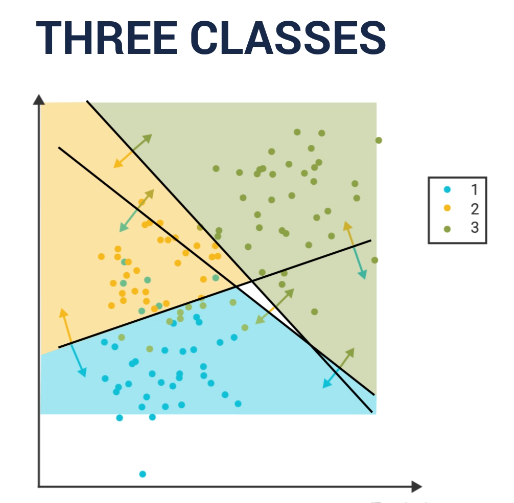

## OVR vs. OVO Compared

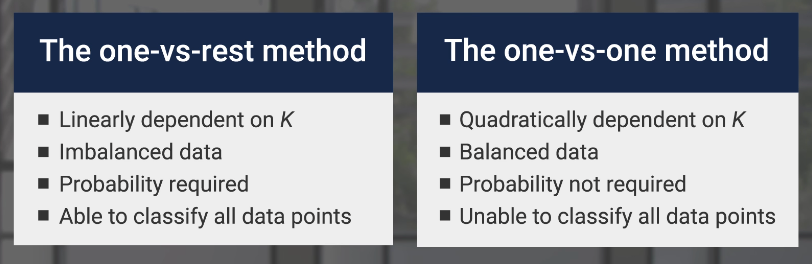

## Multinomial Regression

Most general form
- Similar to OVR in that it calculates a continuous probability for each class
- Similar to OVO in that it calculates models for all pairwise combinations

Start by specifying a reference class, denoted **K**
- Note that choice of this class does not affect the results
- You can use any k for K and get same final predictions
- Build K - 1 logistic regression models by comparing each class to the reference K
- Log odds is log of probability of class 1 divided by probability of class K
- In the equations, the right hand side beta is an (M + 1)-length vector of all beta (1,0:M)
- Also note in highlighted box, it should be K - 1. vs K, not K - vs. K

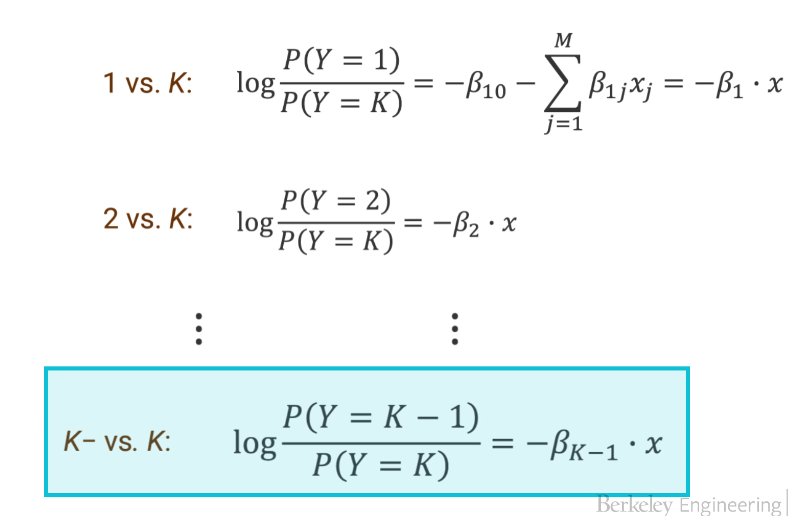

Then you can get any single result P(Y=n) by multiplying by denominator P(Y=K). In the screenshot little k kappa is a class from 1,...,K-1

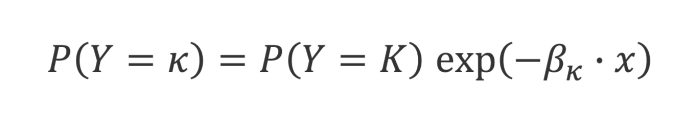

Final expressions here. Note that I think everywhere you see K - 1, (big K), you really mean setdiff(all K, K)
- Because remember capital K is a reference class, not necessarily the last one

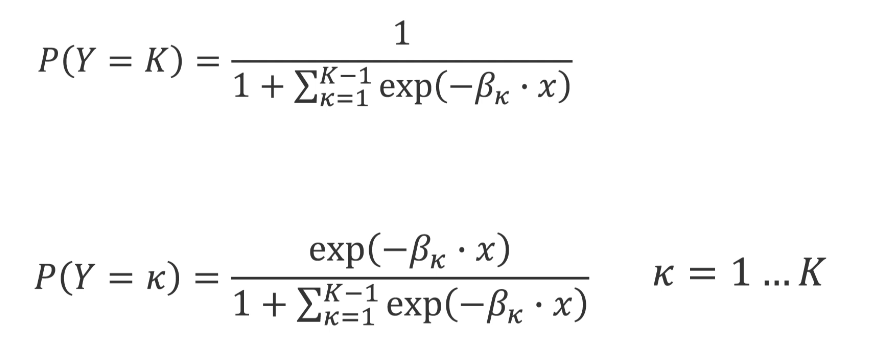

# 13.7 Multiclass in Code

2 inputs, three classes

In [17]:
X = iris[["pl", "pw"]]
y = iris["species"]

## OVR

In [18]:
lr_ovr = LogisticRegression(multi_class="ovr").fit(X, y)
[lr_ovr.intercept_, lr_ovr.coef_]

[array([  7.83255063,  -2.21680713, -17.55616979]),
 array([[-2.59383363, -1.07612405],
        [ 0.88582951, -1.54067185],
        [ 2.77983942,  2.38388751]])]

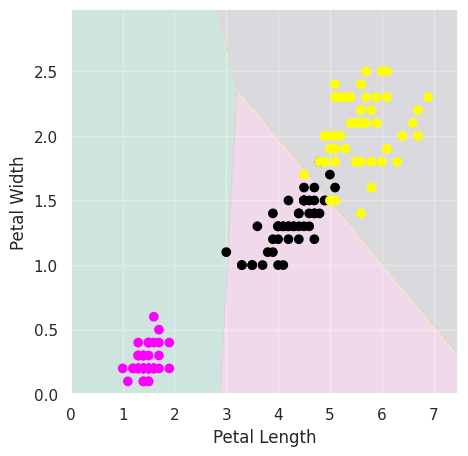

In [19]:
plt.figure(figsize=(5, 5))
plot_region(lr_ovr, [0, 7.5], [0, 3.0])
plt.scatter(
    x=iris["pl"],
    y=iris["pw"],
    c=y.map({0:"magenta", 1: "black", 2: "yellow"}),
)

plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.grid(True)

## Multinomial

In [20]:
lr_multi = LogisticRegression(multi_class="multinomial").fit(X, y)
[lr_multi.intercept_, lr_multi.coef_]

[array([ 11.12427971,   3.22544055, -14.34972026]),
 array([[-2.7476411 , -1.1703017 ],
        [ 0.08364114, -0.90695071],
        [ 2.66399996,  2.07725241]])]

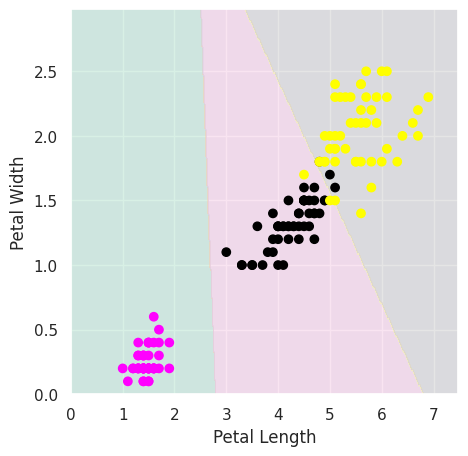

In [21]:
plt.figure(figsize=(5, 5))
plot_region(lr_multi, [0, 7.5], [0, 3.0])
plt.scatter(
    x=iris["pl"],
    y=iris["pw"],
    c=y.map({0:"magenta", 1: "black", 2: "yellow"}),
)

plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.grid(True)

## Feature Selection via Regularization

In [22]:
X = iris_2species.iloc[:, :4]
y = iris_2species["species"]

In [23]:
C = np.logspace(-1.2, -0.5)
coef = np.empty((len(C), 4))
for i, c in enumerate(C):
    coef[i] = LogisticRegression(penalty="l1", C=c, solver="liblinear").fit(X, y).coef_

Make a plot of coefficient absolute value vs. penalty term c
- The plot x axis is reversed so that left to right c goes from bigger to smaller
- Since smaller corresponds to more regularization
- What the plot shows is that sepal width dies off first, so is least important
- Then the petal width dies off
- etc...

Conclusions from that:
- Petal length is most important feature
- If you could include 2 features, include the next most important which is sepal length

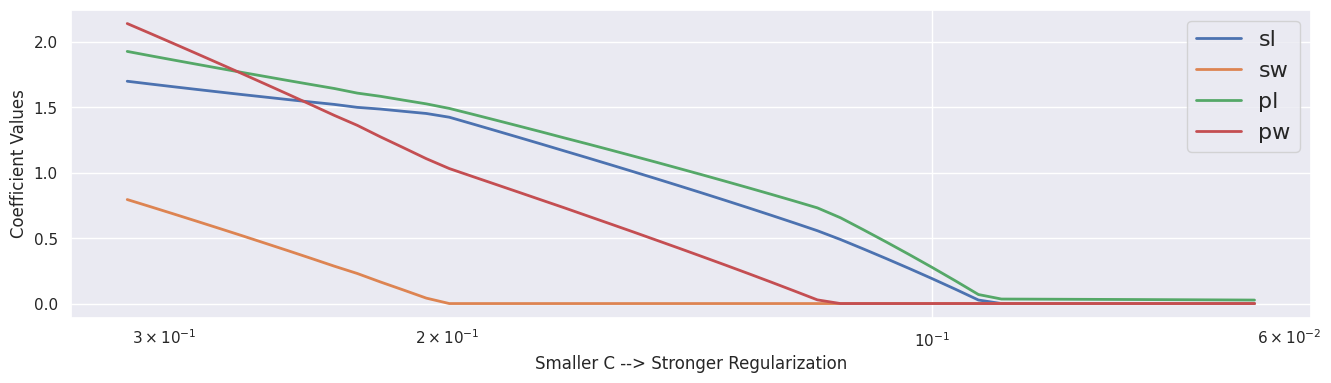

In [24]:
plt.figure()
plt.semilogx(C, abs(coef), linewidth=2)
plt.gca().invert_xaxis()
plt.legend(X.columns, fontsize=16)
plt.xlabel("Smaller C --> Stronger Regularization")
plt.ylabel("Coefficient Values")
plt.show()

# Mini-Lesson on One vs. X

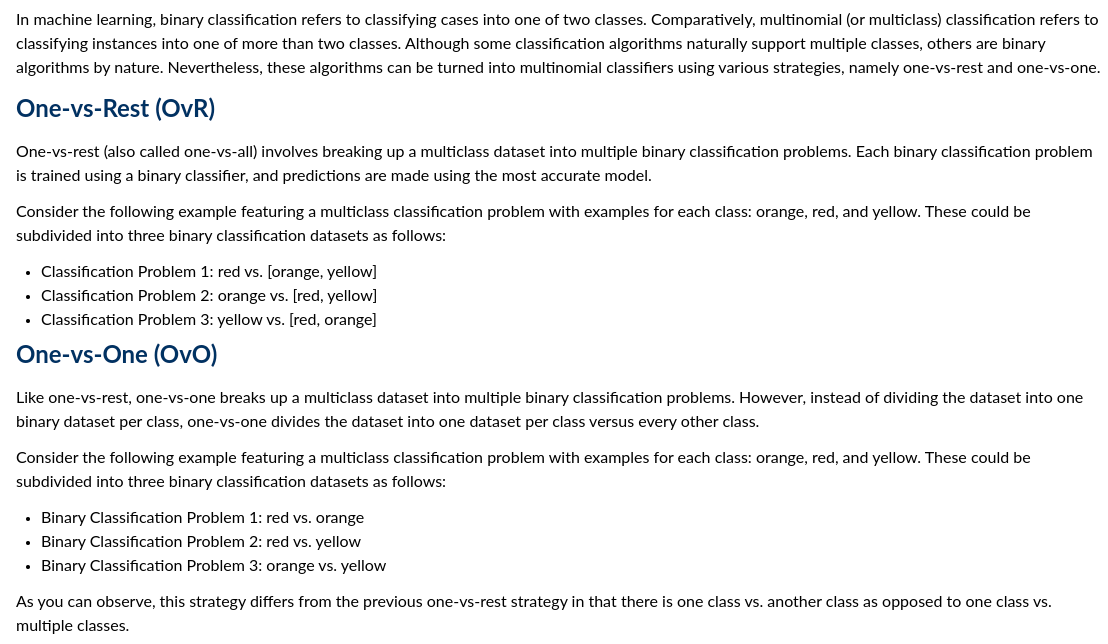